# Querying the Human Lung Cell Atlas

Here we demonstrate how to query the Human Lung Cell Atlas using scANVI.

Sikkema, Lisa, et al. “An integrated cell atlas of the human lung in health and disease.” bioRxiv (2022).

This tutorial is adapted from a similar one presented by the HLCA authors and scANVI tutorial at https://docs.scvi-tools.org/en/stable/tutorials/notebooks/query_hlca_knn.html.

In [26]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pynndescent

import anndata
import scanpy as sc
import scvi

sc.set_figure_params(figsize=(4, 4), dpi=50)

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

## Download the reference files

In [2]:
%%capture
%%bash
wget https://zenodo.org/record/6337966/files/HLCA_reference_model.zip
unzip HLCA_reference_model.zip
rm HLCA_reference_model.zip
mv HLCA_reference_model HLCA_reference_model_legacy

In [3]:
%%capture
%%bash
wget https://bmblx.bmi.osumc.edu/downloadFiles/X202/s1_s2_raw.h5ad

In [4]:
url = "https://zenodo.org/record/6337966/files/HLCA_emb_and_metadata.h5ad"
adata = sc.read("hcla.h5ad", backup_url=url)
adata

AnnData object with n_obs × n_vars = 584884 × 30
    obs: 'sample', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'BMI', 'condition', 'subject_type', 'sample_type', 'single_cell_platform', "3'_or_5'", 'sequencing_platform', 'cell_ranger_version', 'fresh_or_frozen', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_highest_res', 'n_genes', 'log10_total_counts', 'mito_frac', 'ribo_frac', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'scanvi_label', 'leiden_1', 'leiden_2', 'leiden_3', 'anatomical_region_ccf_score', 'entropy_study_leiden_3', 'entropy_dataset_leiden_3', 'entropy_subject_ID_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_original_ann_level_4

In [5]:
# Convert legacy save format to new format.
scvi.model.SCANVI.convert_legacy_save("HLCA_reference_model_legacy", "HLCA_reference_model")

## Learn a neighbors index on reference latent space

In [6]:
X_train = adata.X
ref_nn_index = pynndescent.NNDescent(X_train)
ref_nn_index.prepare()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Load custom query data

In [7]:
path_gene_order = "./HLCA_scarches_gene_order.csv"
query_data_full = sc.read('./s1_s2_raw.h5ad')
reference_gene_order = pd.read_csv(path_gene_order)

In [8]:
reference_gene_order

,gene_id,gene_symbol
0,ENSG00000000938,FGR
1,ENSG00000000971,CFH
2,ENSG00000002587,HS3ST1
3,ENSG00000002933,TMEM176A
4,ENSG00000003436,TFPI
...,...,...
1995,ENSG00000280721,AC133644.2
1996,ENSG00000281103,TRG-AS1
1997,ENSG00000282122,CH17-262H11.1
1998,ENSG00000282988,RP1-34B20.21


In [9]:
# Subset full query data to only HVGs and convert to gene symbols
df1=query_data_full.var
merge_id = df1.merge(reference_gene_order, left_on="features", right_on="gene_symbol", how="left")
query_data_full.var = merge_id
query_data_full.var.index = query_data_full.var['features']
query_data = query_data_full[:, [x for x in merge_id['gene_symbol'] if pd.notna(x)]].copy()
query_data.var.index = query_data.var['gene_id']

In [10]:
query_data

AnnData object with n_obs × n_vars = 9164 × 1754
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribo', 'percent.mito', 'feature.mad.higher', 'count.mad.lower', 'count.mad.higher', 'mito.mad.higher', 'ribo.mad.higher', 'integrated_snn_res.0.1', 'seurat_clusters'
    var: '_index', 'features', 'gene_id', 'gene_symbol'
    obsm: 'X_umap'

## Train model

In [11]:
ref_model_path = "HLCA_reference_model"
scvi.model.SCANVI.prepare_query_anndata(query_data, ref_model_path)

INFO     File HLCA_reference_model/model.pt already downloaded                               
INFO     Found 87.7% reference vars in query data.                                           


In [12]:
query_data.obs["dataset"]= query_data.obs["orig.ident"]
query_data.obs["scanvi_label"] = "unlabeled"
scvi.model.SCANVI.view_setup_args("HLCA_reference_model")

INFO     File HLCA_reference_model/model.pt already downloaded                               


Setup via `SCANVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'dataset',
│   'labels_key': 'scanvi_label',
│   'unlabeled_category': 'unlabeled'
}

In [13]:
query_model = scvi.model.SCANVI.load_query_data(query_data, ref_model_path)

INFO     File HLCA_reference_model/model.pt already downloaded                               


In [14]:
surgery_epochs = 500
train_kwargs_surgery = {
    "early_stopping": True,
    "early_stopping_monitor": "elbo_train",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.001,
    "plan_kwargs": {"weight_decay": 0.0},
}

In [15]:
query_model.train(
    max_epochs=surgery_epochs,
    **train_kwargs_surgery
)

INFO     Training for 500 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 122/500:  24%|██▍       | 122/500 [01:45<05:28,  1.15it/s, loss=454, v_num=1]
Monitored metric elbo_train did not improve in the last 10 records. Best score: 524.400. Signaling Trainer to stop.


In [16]:
query_emb = sc.AnnData(query_model.get_latent_representation())
query_emb.obs_names = query_data.obs_names

In [17]:
import numba
ref_neighbors, ref_distances = ref_nn_index.query(query_emb.X)

# convert distances to affinities
stds = np.std(ref_distances, axis=1)
stds = (2.0 / stds) ** 2
stds = stds.reshape(-1, 1)
ref_distances_tilda = np.exp(-np.true_divide(ref_distances, stds))
weights = ref_distances_tilda / np.sum(
    ref_distances_tilda, axis=1, keepdims=True
)

@numba.njit
def weighted_prediction(weights, ref_cats):
    """Get highest weight category."""
    N = len(weights)
    predictions = np.zeros((N,), dtype=ref_cats.dtype)
    uncertainty = np.zeros((N,))
    for i in range(N):
        obs_weights = weights[i]
        obs_cats = ref_cats[i]
        best_prob = 0
        for c in np.unique(obs_cats):
            cand_prob = np.sum(obs_weights[obs_cats == c])
            if cand_prob > best_prob:
                best_prob = cand_prob
                predictions[i] = c
                uncertainty[i] = max(1 - best_prob, 0)

    return predictions, uncertainty

# for each annotation level, get prediction and uncertainty
label_keys = [f"ann_level_{i}" for i in range(1, 6)] + ["ann_finest_level"]
for l in label_keys:
    ref_cats = adata.obs[l].cat.codes.to_numpy()[ref_neighbors]
    p, u = weighted_prediction(weights, ref_cats)
    p = np.asarray(adata.obs[l].cat.categories)[p]
    query_emb.obs[l + "_pred"], query_emb.obs[l + "_uncertainty"] = p, u


In [18]:
uncertainty_threshold = 0.2
for l in label_keys:
    mask = query_emb.obs[l + "_uncertainty"] > 0.2
    print(f"{l}: {sum(mask)/len(mask)} unknown")
    query_emb.obs[l + "_pred"].loc[mask] = "Unknown"
query_emb.obs["dataset"] = "test_dataset_delorey_regev"

ann_level_1: 0.0005456132693147098 unknown
ann_level_2: 0.004364906154517678 unknown
ann_level_3: 0.10235704932343954 unknown
ann_level_4: 0.2936490615451768 unknown
ann_level_5: 0.25327367961588826 unknown
ann_finest_level: 0.3395896988214753 unknown


/tmp/ipykernel_2100524/2831657114.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  query_emb.obs[l + "_pred"].loc[mask] = "Unknown"


## Combine embeddings

In [19]:
combined_emb = adata.concatenate(query_emb)

In [20]:
from scvi.model.utils import mde

combined_emb.obsm["X_mde"] = mde(combined_emb.X, init="random")

## Visualize embeddings and predictions

To visualize here we use minimum distortion embeddings, which for now can be thought of as an alternative of UMAP that is GPU-accelerated (= really fast on Colab). While we use init="random" here, we recommend removing this argument in practice and only leave it here to make the notebook run faster.

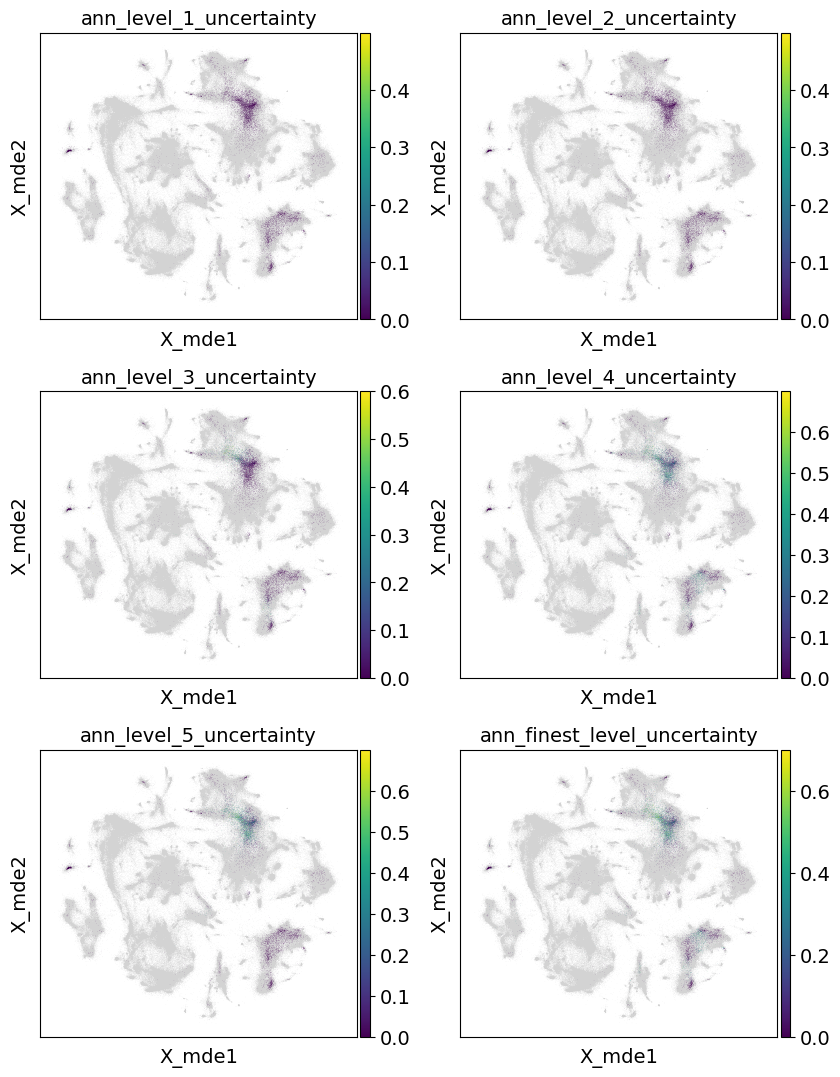

In [27]:
colors = [l + "_uncertainty" for l in label_keys]
sc.pl.embedding(
    combined_emb,
    basis="X_mde",
    color=colors,
    ncols=2,
)

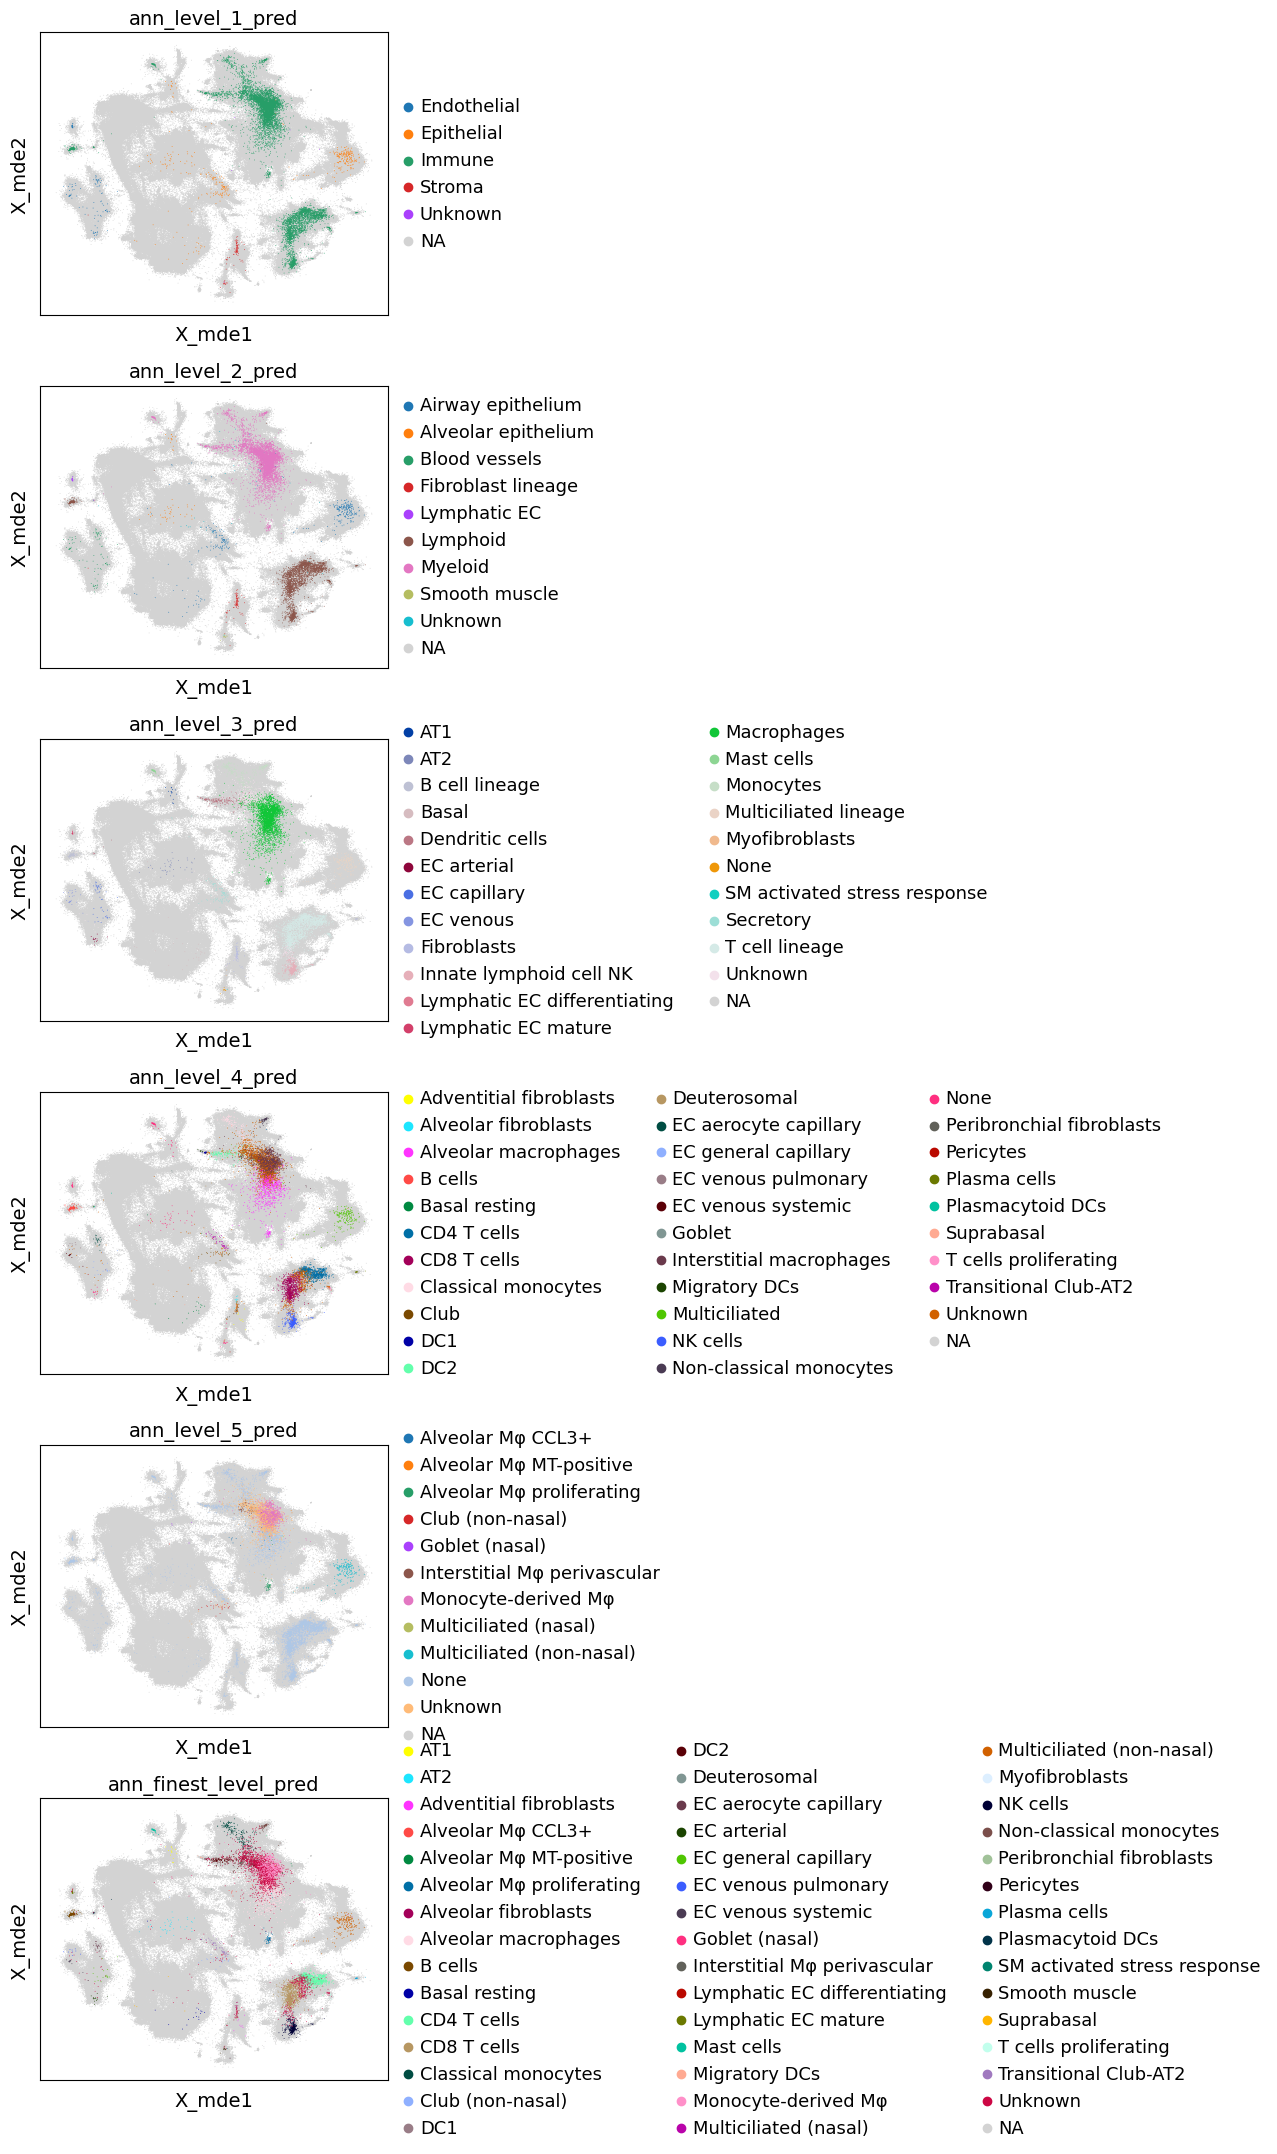

In [28]:
colors = [l + "_pred" for l in label_keys]

sc.pl.embedding(combined_emb, basis="X_mde", color=colors, ncols=1, size=1.5) 


In [23]:
query_emb

AnnData object with n_obs × n_vars = 9164 × 30
    obs: 'ann_level_1_pred', 'ann_level_1_uncertainty', 'ann_level_2_pred', 'ann_level_2_uncertainty', 'ann_level_3_pred', 'ann_level_3_uncertainty', 'ann_level_4_pred', 'ann_level_4_uncertainty', 'ann_level_5_pred', 'ann_level_5_uncertainty', 'ann_finest_level_pred', 'ann_finest_level_uncertainty', 'dataset'

## Save results

In [24]:
# Save embedding and object
query_emb.obs.to_csv('./query_emb.csv')
combined_emb.write_h5ad("./s1_s2_SCANVI.h5ad")

In [25]:
# Save trained model
query_save_path = "hcla_query/"
query_model.save(query_save_path, overwrite=True)